In [40]:
import gc
import numpy as np
from omegaconf import DictConfig
import os
import pandas as pd
import lightning.pytorch as pl
import torch
from tqdm import tqdm
import yaml

from lightning_pose.data.dali import PrepareDALI
from lightning_pose.utils.io import ckpt_path_from_base_path
from lightning_pose.utils.predictions import (
    get_cfg_file, 
    predict_single_video, 
    load_model_from_checkpoint, 
    PredictionHandler,
)
from lightning_pose.utils.scripts import (
    compute_metrics,
    get_imgaug_transform, 
    get_dataset, 
    get_data_module,
)

from eks.utils import convert_lp_dlc, make_output_dataframe, populate_output_dataframe
from eks.singlecam_smoother import ensemble_kalman_smoother_singlecam

from pseudo_labeler.utils import format_data_walk
from pseudo_labeler.evaluation import (
    compute_likelihoods_and_variance,
    compute_ensemble_stddev,
    compute_percentiles,
    cleanaxis,
    find_model_dirs
)

dataset_name = "mirror-mouse"
n_hand_labels = 100
n_pseudo_labels = 1000
seeds=[0, 1, 2, 3]
selection_strategy="random"

# set eks_relative to true if comparing to EKS
eks_relative = False
pseudo_labeler = 'eks'
file_name = 'test_vid' 

# network models location
networks_dir = f"/teamspace/studios/this_studio/outputs/{dataset_name}/hand={n_hand_labels}_pseudo={n_pseudo_labels}/networks"

# eks/post-processor output location
eks_save_dir = f"/teamspace/studios/this_studio/outputs/{dataset_name}/hand={n_hand_labels}_pseudo={n_pseudo_labels}/post-processors/eks_rng={seeds[0]}-{seeds[-1]}/eks_ood_snippets"

aeks_random_dir = f"/teamspace/studios/this_studio/outputs/{dataset_name}/hand={n_hand_labels}_pseudo={n_pseudo_labels}/results_aeks_random"

# --------------------------------
# Define path for ground truth csv
# --------------------------------

if eks_relative:
    ground_truth_csv = os.path.join(eks_save_dir, f"../{file_name}.csv")
else:
    ground_truth_csv = f"/teamspace/studios/this_studio/data/{dataset_name}/CollectedData_new.csv"



In [41]:
model_dirs_list = []
if dataset_name == "mirror-mouse":
    model_dirs_list = find_model_dirs(networks_dir, 'rng')
    print(f"Found {len(model_dirs_list)} model directories")
    keypoint_ensemble_list = [
        'paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'nose_top', 'tailBase_top', 'tailMid_top',
        'paw1LH_bot', 'paw2LF_bot', 'paw3RF_bot', 'paw4RH_bot', 'nose_bot', 'tailBase_bot', 'tailMid_bot',
    ]
elif dataset_name == "crim13":
    model_dirs_list = find_model_dirs(networks_dir, 'rng')
    print(f"Found {len(model_dirs_list)} model directories")
    keypoint_ensemble_list = [
        'black_mouse_nose', 'black_mouse_right_ear',
        'black_mouse_left_ear', 'black_mouse_top_of_neck',
        'black_mouse_right_rear_knee', 'black_mouse_left_rear_knee',
        'black_mouse_base_of_tail', 'white_mouse_nose',
        'white_mouse_right_ear', 'white_mouse_left_ear',
        'white_mouse_top_of_neck', 'white_mouse_right_rear_knee',
        'white_mouse_left_rear_knee', 'white_mouse_base_of_tail'
    ]
else:
    raise NotImplementedError


Found 4 model directories


In [42]:
if eks_relative:
    data_to_plot = {}
    data_to_plot[f'aeks_{selection_strategy}_{pseudo_labeler}'] = os.path.join(
        aeks_random_dir,
        f'{pseudo_labeler}_rng={seeds[0]}-{seeds[-1]}/{file_name}.csv'
        )
    for seed in seeds:
        key = f'aeks_{selection_strategy}_rng{seed}'
        value = os.path.join(aeks_random_dir, f'rng{seed}/video_preds', (
                f'hand={n_hand_labels}_rng={seed}_pseudo={n_pseudo_labels}'
                f'_{pseudo_labeler}_{selection_strategy}_rng={seeds[0]}-{seeds[-1]}'
                f'_{file_name}.csv'
            )
        )
        data_to_plot[key] = value
else:
    aeks_hand_dir = os.path.join(aeks_random_dir, '../results_aeks_hand')
    data_to_plot = {
        #'networks_rng0': os.path.join(networks_dir, 'rng0/video_preds_labeled/predictions_new.csv'),
        #'networks_rng1': os.path.join(networks_dir, 'rng1/video_preds_labeled/predictions_new.csv'),
        #'networks_rng2': os.path.join(networks_dir, 'rng2/video_preds_labeled/predictions_new.csv'),
        #'networks_rng3': os.path.join(networks_dir, 'rng3/video_preds_labeled/predictions_new.csv'),
        #'networks_rng6': os.path.join(networks_dir, 'rng6/video_preds_labeled/predictions_new.csv'),
        #'networks_rng5': os.path.join(networks_dir, 'rng5/video_preds_labeled/predictions_new.csv'),
        #'networks_rng7': os.path.join(networks_dir, 'rng7/video_preds_labeled/predictions_new.csv'),
        #'networks_rng8': os.path.join(networks_dir, 'rng8/video_preds_labeled/predictions_new.csv'),
        #'networks_rng9': os.path.join(networks_dir, 'rng9/video_preds_labeled/predictions_new.csv'),
        'eks': os.path.join(eks_save_dir, 'eks/predictions_new.csv'),
        #'ens-mean': os.path.join(eks_save_dir, 'ens-mean/predictions_new.csv'),
        #'ens-median': os.path.join(eks_save_dir, 'ens-median/predictions_new.csv'),
        #'aeks_random_rng0': os.path.join(aeks_random_dir, 'rng0/video_preds_labeled/predictions_new.csv'),
        #'aeks_random_rng1': os.path.join(aeks_random_dir, 'rng1/video_preds_labeled/predictions_new.csv'),
        #'aeks_random_rng2': os.path.join(aeks_random_dir, 'rng2/video_preds_labeled/predictions_new.csv'),
        #'aeks_random_rng3': os.path.join(aeks_random_dir, 'rng3/video_preds_labeled/predictions_new.csv'),
        'aeks_random_eks': os.path.join(aeks_random_dir, 'eks_rng=0-3/eks_ood_snippets/eks/predictions_new.csv'),
        #'aeks_hand_rng0': os.path.join(aeks_hand_dir, 'rng0/predictions_new.csv'),
        #'aeks_hand_rng1': os.path.join(aeks_hand_dir, 'rng1/predictions_new.csv'),
        #'aeks_hand_rng2': os.path.join(aeks_hand_dir, 'rng2/predictions_new.csv'),
        #'aeks_hand_rng3': os.path.join(aeks_hand_dir, 'rng3/predictions_new.csv'),
        'aeks_hand_eks': os.path.join(aeks_hand_dir, 'eks_rng=0-3/eks_ood_snippets/eks/predictions_new.csv'),
        # 'aeks_ens-mean': os.path.join(aeks_random_dir, 'eks_rng=0-3/ens-mean/predictions_new.csv'),
        # 'aeks_ens-median': os.path.join(aeks_random_dir, 'eks_rng=0-3/ens-median/predictions_new.csv'),
        #'aeks_new_rng0' : "/teamspace/studios/nutty-azure-ulnn/outputs/mirror-mouse/hand=100_pseudo=1000/results_aeks_frame_selection/rng0/video_preds_labeled/predictions_new.csv",
        #'aeks_new_rng1' : "/teamspace/studios/nutty-azure-ulnn/outputs/mirror-mouse/hand=100_pseudo=1000/results_aeks_frame_selection/rng1/video_preds_labeled/predictions_new.csv",
        #'aeks_new_rng2' : "/teamspace/studios/nutty-azure-ulnn/outputs/mirror-mouse/hand=100_pseudo=1000/results_aeks_frame_selection/rng2/video_preds_labeled/predictions_new.csv",
        #'aeks_new_rng3' : "/teamspace/studios/nutty-azure-ulnn/outputs/mirror-mouse/hand=100_pseudo=1000/results_aeks_frame_selection/rng3/video_preds_labeled/predictions_new.csv",
        'aeks_new_eks' : "/teamspace/studios/nutty-azure-ulnn/outputs/mirror-mouse/hand=100_pseudo=1000/results_aeks_frame_selection/eks_rng=0-3/eks_ood_snippets/eks/predictions_new.csv",

    }


In [43]:
# define predictions so we can compute ensemble variance
pred_csv_list = []
# define model names
model_names_list = []
# reformat
for key, val in data_to_plot.items():
    model_names_list.append(key)
    pred_csv_list.append(val)

if eks_relative:
    error_csv_dir = os.path.join(networks_dir, f"../eks_aeks_pixel_diff/{file_name}/relative_pixel_error")
    error_csv_list = []
    for p in pred_csv_list:
        basename = os.path.basename(p)
        if 'hand' in basename:
            search_term = os.path.basename(os.path.abspath(os.path.join(p, '../..')))
        else:
            search_term = 'aeks_eks'
        print(search_term)
        for csv in os.listdir(error_csv_dir):
            if search_term in csv:
                error_csv_list.append(os.path.join(error_csv_dir, csv))

    print(error_csv_list)

else:
    error_csv_list = [p.replace('.csv', '_pixel_error.csv') for p in pred_csv_list]
    print(error_csv_list)

# load data
df_pred_list = []
df_error_list = []
for pred_csv, error_csv in zip(pred_csv_list, error_csv_list):
#     df_pred_list.append(pd.read_csv(pred_csv, header=[0, 1, 2], index_col=0).drop(columns=['set']))
#     df_error_list.append(pd.read_csv(error_csv, header=[0], index_col=0).drop(columns=['set']))
    
    df_pred_list.append(pd.read_csv(pred_csv, header=[0, 1, 2], index_col=0).sort_index())
    df = pd.read_csv(error_csv, header=[0], index_col=0).sort_index()
    if 'set' in df.columns:
        df = df.drop(columns=['set'])
    df_error_list.append(df)


['/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/post-processors/eks_rng=0-3/eks_ood_snippets/eks/predictions_new_pixel_error.csv', '/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_aeks_random/eks_rng=0-3/eks_ood_snippets/eks/predictions_new_pixel_error.csv', '/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_aeks_random/../results_aeks_hand/eks_rng=0-3/eks_ood_snippets/eks/predictions_new_pixel_error.csv', '/teamspace/studios/nutty-azure-ulnn/outputs/mirror-mouse/hand=100_pseudo=1000/results_aeks_frame_selection/eks_rng=0-3/eks_ood_snippets/eks/predictions_new_pixel_error.csv']


In [44]:
# compute ensemble variance
df_gt = pd.read_csv(ground_truth_csv, header=[0, 1, 2], index_col=0)
df_gt.sort_index(inplace=True)
print(df_pred_list)
ens_stddev = compute_ensemble_stddev(
    df_gt,
    df_pred_list,
    keypoint_ensemble_list
)

[scorer                                ensemble-kalman_tracker              \
bodyparts                                          paw1LH_top               
coords                                                      x           y   
labeled-data/180607_004/img015278.png              141.143143   98.453461   
labeled-data/180607_004/img015320.png              136.700989  100.623528   
labeled-data/180607_004/img015814.png               97.682220  119.977722   
labeled-data/180607_004/img015879.png              106.786530  102.199867   
labeled-data/180607_004/img016209.png               64.445435  132.751526   
...                                                       ...         ...   
labeled-data/180623_000/img107228.png               90.792328  110.406898   
labeled-data/180623_000/img107258.png               79.502792   58.461021   
labeled-data/180623_000/img107262.png               68.591003   60.830479   
labeled-data/180623_000/img107273.png              186.389694  100.114594  

In [45]:
# Record pixel errors along with ensemble variances
df_w_vars = []
for df_error, model_name in zip(df_error_list, model_names_list):
    # Ensure df_error has the same index as df_gt
    df_error.index = df_gt.index
    
    # Calculate total pixel error (sum) for each df_error and print it
    total_pixel_error = df_error.sum().sum()
    print(f"Total pixel error for model {model_name}: {total_pixel_error}")

    for i, kp in enumerate(df_error.columns):
        df_w_vars.append(pd.DataFrame({
            'pixel_error': df_error[kp],
            'ens-std': ens_stddev[:, i],
            'ens-std-prctile': [np.sum(ens_stddev < p) / ens_stddev.size for p in ens_stddev[:, i]],
            'ens-std-prctile-kp': [np.sum(ens_stddev[:, i] < p) / ens_stddev[:, i].size for p in ens_stddev[:, i]], 
            'keypoint': kp,
            'model': model_name,
        }, index=df_error.index))

df_w_vars = pd.concat(df_w_vars)

Total pixel error for model eks: 21969.969992456892
Total pixel error for model aeks_random_eks: 20907.847028062013
Total pixel error for model aeks_hand_eks: 18982.732843964615
Total pixel error for model aeks_new_eks: 21203.94735242232


In [46]:
std_vals = np.arange(0, 5, 0.4)

n_points_dict = {m: np.nan * np.zeros_like(std_vals) for m in model_names_list}
df_line2 = []
for s, std in enumerate(std_vals):
    df_tmp_ = df_w_vars[df_w_vars['ens-std'] > std]
    for model_name in model_names_list:
        d = df_tmp_[df_tmp_.model == model_name]
        n_points = np.sum(~d['pixel_error'].isna())
        n_points_dict[model_name][s] = n_points
        index = []
        rng = 0
        for row, k in zip(d.index, d['keypoint'].to_numpy()):
            index.append(f'{row}' + f'_{model_name}_{s}_{k}_{rng}')
        df_line2.append(pd.DataFrame({
            'ens-std': std,
            'model': model_name,
            'mean': d.pixel_error.to_numpy(),
            'n_points': n_points,
        }, index=index))
df_line2 = pd.concat(df_line2)

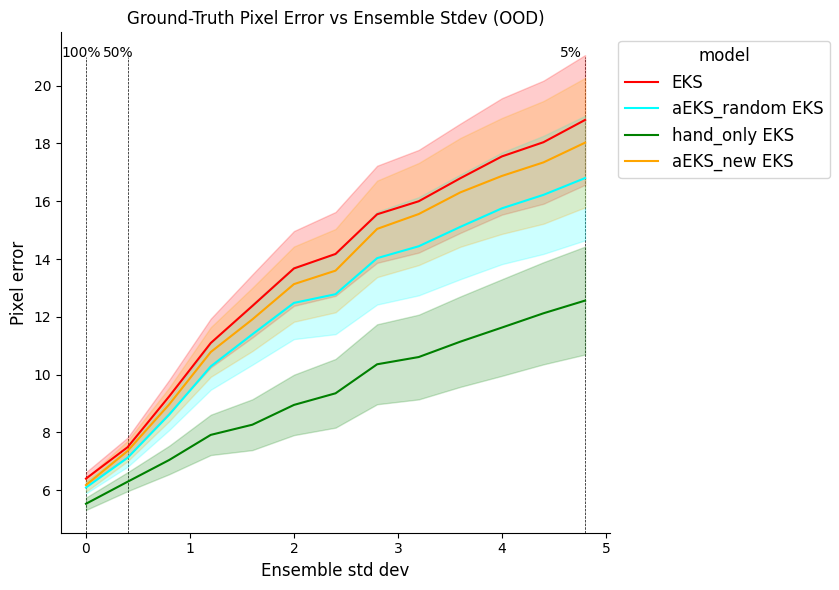

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the color mapping
color_mapping = {
    'networks': 'pink',
    'eks': 'red',
    'ens-mean': 'lightgreen',
    'ens-median': 'green',
    'aeks_hand_rng': 'lightgreen',
    'aeks_hand_eks': 'green',
    'aeks_random_rng': 'lightblue',
    'aeks_random_eks': 'cyan',
    'aeks_ens-mean': 'orange',
    'aeks_ens-median': 'red',
    'aeks_new_rng' : 'lightyellow',
    'aeks_new_eks' : 'orange'
}

# Create a color list based on the model names
def get_color(name):
    if 'aeks_ens-median' in name:
        return color_mapping['aeks_ens-median']
    elif 'aeks_ens-mean' in name:
        return color_mapping['aeks_ens-mean']
    elif 'aeks_hand_rng' in name:
        return color_mapping['aeks_hand_rng']
    elif 'aeks_hand_eks' in name:
        return color_mapping['aeks_hand_eks']
    elif 'aeks_random_rng' in name:
        return color_mapping['aeks_random_rng']
    elif 'aeks_random_eks' in name:
        return color_mapping['aeks_random_eks']
    elif 'aeks_new_rng' in name:
        return color_mapping['aeks_new_rng']
    elif 'aeks_new_eks' in name:
        return color_mapping['aeks_new_eks']
    else:
        base_name = name.split('_')[0]
        return color_mapping.get(base_name, 'gray')

palette = [get_color(name) for name in df_line2['model'].unique()]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))  # Increase the figure size

g = sns.lineplot(
    x='ens-std',
    y='mean',
    hue='model',
    hue_order=model_names_list,
    palette=palette,
    data=df_line2,
    ax=ax,
    errorbar='se'
)

labels_fontsize = 12
if eks_relative:
    ax.set_title(f'EKS-Relative Pixel Error vs Ensemble Stdev (OOD)', fontsize=labels_fontsize)
    ax.set_ylabel('EKS-Relative Pixel error', fontsize=labels_fontsize)
else:
    ax.set_title(f'Ground-Truth Pixel Error vs Ensemble Stdev (OOD)', fontsize=labels_fontsize)
    ax.set_ylabel('Pixel error', fontsize=labels_fontsize)
ax.set_xlabel('Ensemble std dev', fontsize=labels_fontsize)
cleanaxis(ax)

# Customize legend
legend_labels = {
    'networks': 'Networks',
    'eks': 'EKS',
    'ens-mean': 'Ensemble Mean',
    'ens-median': 'Ensemble Median',
    'aeks_hand_rng': 'hand_only',
    'aeks_hand_eks': 'hand_only EKS',
    'aeks_random_rng': 'aEKS_random',
    'aeks_random_eks': 'aEKS_random EKS',
    'aeks_new_rng' : 'aEKS_new',
    'aeks_new_eks' : 'aEKS_new EKS',
    'aeks_ens-mean': 'aEKS Ensemble Mean',
    'aeks_ens-median': 'aEKS Ensemble Median',
}

# Combine similar models into single legend entries
handles, labels = ax.get_legend_handles_labels()
unique_labels = []
unique_handles = []

for handle, label in zip(handles, labels):
    if 'aeks_ens-median' in label:
        base_label = 'aeks_ens-median'
    elif 'aeks_ens-mean' in label:
        base_label = 'aeks_ens-mean'
    elif 'aeks_hand_rng' in label:
        base_label = 'aeks_hand_rng'
    elif 'aeks_hand_eks' in label:
        base_label = 'aeks_hand_eks'
    elif 'aeks_random_rng' in label:
        base_label = 'aeks_random_rng'
    elif 'aeks_random_eks' in label:
        base_label = 'aeks_random_eks'
    elif 'aeks_new_rng' in label:
        base_label = 'aeks_new_rng'
    elif 'aeks_new_eks' in label:
        base_label = 'aeks_new_eks'
    else:
        base_label = label.split('_')[0]

    if base_label not in unique_labels:
        unique_labels.append(base_label)
        unique_handles.append(handle)

ax.legend(
    handles=unique_handles,
    labels=[legend_labels.get(label, label) for label in unique_labels],
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=labels_fontsize,
    title='model',
    title_fontsize=labels_fontsize
)

# Plot annotations
percentiles = [100, 50, 1]
vals, prctiles = compute_percentiles(
    arr=n_points_dict[model_names_list[0]],
    std_vals=std_vals,
    percentiles=percentiles,
)

for p, v in zip(prctiles, vals):
    ax.axvline(v, ymax=0.95, linestyle='--', linewidth=0.5, color='k', zorder=-1)
    ax.text(
        v / np.diff(ax.get_xlim()), 0.95, str(round(p)) + '%',
        transform=ax.transAxes,
        ha='left',
    )

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.show()
